In [2]:
%matplotlib_svg
import numpy as np
import pylab as pl
import cv2
from cv2 import cv

# OpenCV-图像处理和计算机视觉

In [1]:
import cv2
from cv2 import cv

## 图像的输入输出

### 读入并显示图像

In [6]:
filename = "lena.jpg"
img = cv2.imread( filename ) #❶
print((type(img), img.shape, img.dtype))
cv2.namedWindow("demo1")     #❷
cv2.imshow("demo1", img)     #❸
cv2.waitKey(0)  #❹;

<type 'numpy.ndarray'> (512, 512, 3) uint8


> **WARNING**

> `imread()`函数读入彩色图像时，第2轴按照蓝、绿、红的顺序排列。这种顺序与`matplotlib`的`imshow()`函数所需的三通道的顺序正好相反，因此若需要在`matplotlib`中显示图像，需要反转第2轴：`img[:, :, ::-1]`。

> **TIP**

> 在IPython Notebook显示窗口时，`waitKey(0)`会阻塞运算核，因此无法再运行其它命令。为了不阻塞运行，可以在新的线程中显示窗口，并等待窗口关闭。例如通过本书提供的`%%thread`魔法命令。

In [4]:
%%thread
#%hidecell
filename = "lena.jpg"
img = cv2.imread( filename )
cv2.namedWindow("demo1")
cv2.imshow("demo1", img)
cv2.waitKey(0)

> **TIP**

> `cv2`模块下的图像处理函数都能直接对NumPy数组进行操作，在这些函数内部会将NumPy数组转换成OpenCV中表示图像的对象，并传递给实际进行运算的C/C++函数。虽然在调用`cv2`模块下的函数时会进行类型转换，但是NumPy数组与OpenCV的图像对象能够共享内存，因此并不会太浪费内存和CPU运算时间。

In [10]:
img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
print((img_gray.shape))

(512, 512)


### 图像类型

In [4]:
#%hide
from matplotlib import cm
from itertools import product

def func(x, y):
    return (x+y)*np.exp(-5.0*(x**2 + y**2))

y, x = np.mgrid[-1:1:100j, -1:1:100j]
z = func(x, y)
zabs = np.abs(z)
alpha = cm.ScalarMappable(cmap="gray").to_rgba(zabs)[:, :, 0].copy()
z1 = cm.ScalarMappable(cmap="gray").to_rgba(z)[:, :, 0].copy()
z4 = cm.ScalarMappable(cmap="jet").to_rgba(z)
z3 = z4[:, :, 2::-1].copy()
z4[:, :, -1] = alpha
z4[:, :, :3] = z3

for dtype, img in product(["uint8", "uint16"], [z1, z3, z4]):
    nchannel = 1 if img.ndim == 2 else img.shape[2]
    img = (img * np.iinfo(dtype).max).astype(dtype)
    fn = "{}_{}.png".format(dtype, nchannel)
    cv2.imwrite(fn, img)

In [5]:
#%hide
from glob import glob
from IPython import display
from scpy2.utils import tabulate_it

files = glob("uint*.png")
flags = ["ANYCOLOR",
"ANYDEPTH",
"COLOR",
"GRAYSCALE",
"UNCHANGED"]

def f(fn, flag):
    _flag = getattr(cv2, "IMREAD_" + flag)
    img = cv2.imread(fn, _flag)
    nchannel = 1 if img.ndim == 2 else img.shape[2]
    return "{}, {}ch".format(img.dtype, nchannel)

table = tabulate_it(files, flags, f)
display.display_markdown(display.Markdown(table))

|                  | **ANYCOLOR**   | **ANYDEPTH**   | **COLOR**   | **GRAYSCALE**   | **UNCHANGED**   |
|:-----------------|:---------------|:---------------|:------------|:----------------|:----------------|
| **uint16_1.png** | uint8, 1ch     | uint16, 1ch    | uint8, 3ch  | uint8, 1ch      | uint16, 1ch     |
| **uint16_3.png** | uint8, 3ch     | uint16, 1ch    | uint8, 3ch  | uint8, 1ch      | uint16, 3ch     |
| **uint16_4.png** | uint8, 3ch     | uint16, 1ch    | uint8, 3ch  | uint8, 1ch      | uint16, 4ch     |
| **uint8_1.png**  | uint8, 1ch     | uint8, 1ch     | uint8, 3ch  | uint8, 1ch      | uint8, 1ch      |
| **uint8_3.png**  | uint8, 3ch     | uint8, 1ch     | uint8, 3ch  | uint8, 1ch      | uint8, 3ch      |
| **uint8_4.png**  | uint8, 3ch     | uint8, 1ch     | uint8, 3ch  | uint8, 1ch      | uint8, 4ch      |

### 图像输出

In [14]:
img = cv2.imread("lena.jpg")
for quality in [90, 60, 30]:
    cv2.imwrite("lena_q{:02d}.jpg".format(quality), img, 
                [cv2.IMWRITE_JPEG_QUALITY, quality])

In [ ]:
from matplotlib.cm import ScalarMappable
from IPython.display import Image

def func(x, y, a):
    return (x*x - y*y) * np.sin((x + y) / a) / (x*x + y*y)

def make_image(x, y, a, dtype="uint8"):
    z = func(x, y, a) #❶
    img_rgba = ScalarMappable(cmap="jet").to_rgba(z)
    img = (img_rgba[:, :, 2::-1] * np.iinfo(dtype).max).astype(dtype) #❷
    return img

In [24]:
y, x = np.ogrid[-10:10:250j, -10:10:500j]
img_8bit = make_image(x, y, 0.5, dtype="uint8")
img_16bit = make_image(x, y, 0.5, dtype="uint16")
cv2.imwrite("img_8bit.jpg", img_8bit)
cv2.imwrite("img_16bit.jpg", img_16bit)
cv2.imwrite("img_8bit.png", img_8bit)
cv2.imwrite("img_16bit.png", img_16bit);

### 字节序列与图像相互转换

In [25]:
with open("img_8bit.png", "rb") as f:
    png_str = f.read()
    
png_data = np.frombuffer(png_str, np.uint8) #❶
img = cv2.imdecode(png_data, cv2.IMREAD_UNCHANGED) #❷
res, jpg_data = cv2.imencode(".jpg", img) #❸
jpg_str = jpg_data.tobytes() #❹

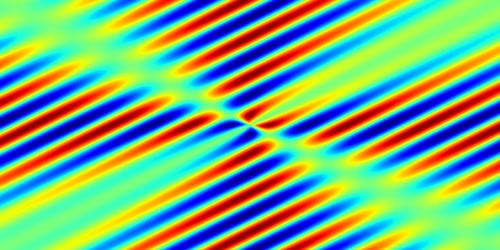

In [26]:
#%fig=使用`Image`将`imencode()`编码的结果直接嵌入到Notebook中
res, jpg_data = cv2.imencode(".jpg", img_8bit) 
Image(data=jpg_data.tobytes())

### 视频输出

In [13]:
def test_avi_output(fn, fourcc):
    fourcc = cv.FOURCC(*fourcc) #❶
    vw = cv2.VideoWriter(fn, fourcc, 15, (500, 250), True) #❷
    if not vw.isOpened():
        return 
    for a in np.linspace(0.1, 2, 100):
        img = make_image(x, y, a)
        vw.write(img)  #❸
    vw.release()  #❹
    
test_avi_output("fmp4.avi", "fmp4")

> **SOURCE**

> `scpy2.opencv.fourcc`：查看选中的视频编码器对应的`FOURCC`代码。

In [8]:
#%hide
%exec_python -m scpy2.opencv.fourcc

> **LINK**

> http://sourceforge.net/projects/x264vfw/

> x264vfw编码器的下载地址

In [43]:
from scpy2.opencv.x264_settings import set_quantizer
from os import path

for quantizer in [1, 10, 20, 30, 40]:
    set_quantizer(quantizer)
    fn = "x264_q{:02d}.avi".format(quantizer)
    test_avi_output(fn, "x264")
    fsize = path.getsize(fn)
    print(("quantizer = {:02d}, size = {:07d} bytes".format(quantizer, fsize)))

quantizer = 01, size = 5686272 bytes
quantizer = 10, size = 2406912 bytes
quantizer = 20, size = 0932864 bytes
quantizer = 30, size = 0396288 bytes
quantizer = 40, size = 0189952 bytes


### 视频输入

In [28]:
video = cv2.VideoCapture("x264_q10.avi")
print(("FPS:", video.get(cv.CV_CAP_PROP_FPS))) #❶
print(("FRAMES:", video.get(cv.CV_CAP_PROP_FRAME_COUNT)))
print(("WIDTH:", video.get(cv.CV_CAP_PROP_FRAME_WIDTH)))
print(("HEIGHT:", video.get(cv.CV_CAP_PROP_FRAME_HEIGHT)))
print(("CURRENT FRAME:", video.get(cv.CV_CAP_PROP_POS_FRAMES)))
res, frame0 = video.read() #❷
print(("CURRENT FRAME:", video.get(cv.CV_CAP_PROP_POS_FRAMES)))
video.set(cv.CV_CAP_PROP_POS_FRAMES, 50) #❸
print(("CURRENT FRAME:", video.get(cv.CV_CAP_PROP_POS_FRAMES)))
res, frame50 = video.read()
print(("CURRENT FRAME:", video.get(cv.CV_CAP_PROP_POS_FRAMES)))
video.release()

FPS: 15.0
FRAMES: 100.0
WIDTH: 500.0
HEIGHT: 250.0
CURRENT FRAME: 0.0
CURRENT FRAME: 1.0
CURRENT FRAME: 50.0
CURRENT FRAME: 51.0


In [8]:
camera = cv2.VideoCapture(0)
res, frame = camera.read()
camera.release()
print((res, frame.shape))

 True (480, 640, 3)
